# CLIP

In [26]:
USE_SUBSET = True
BERT_RESNET = False
BERT_VIT = False
GPT_VIT = True
TRAIN_MODELS = False

SUBSET_SIZE = 100
DATA_PATH = './data/'

## Imports

In [2]:
import os
import time
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models import resnet50, ResNet50_Weights, mobilenet_v2
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model, GPT2Config, ViTModel, ViTConfig
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16

### Import data

In [3]:
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, tokenizer=None, max_len=128):
        # Charger le CSV et vérifier que les IDs sont valides
        self.data = pd.read_csv(csv_file, on_bad_lines='skip')
        self.data = self.data.dropna(subset=['id'])  # Supprime les lignes sans 'id'
        self.data['productDisplayName'] = self.data['productDisplayName'].fillna("Description manquante").astype(str)

        # Dossier des images
        self.img_dir = img_dir

        # Transformations et tokenizer
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len

        def image_exists(row):
            img_path = f"{self.img_dir}/{int(row['id'])}.jpg"
            return os.path.exists(img_path)

        # Pré-filtrer les données pour éviter les images inexistantes
        self.data = self.data[self.data.apply(image_exists, axis=1)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Récupérer une ligne du dataset
        row = self.data.iloc[idx]

        # Générer le chemin de l'image à partir de l'ID
        img_path = f"{self.img_dir}/{int(row['id'])}.jpg"

        # Charger et transformer l'image
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise FileNotFoundError(f"L'image {img_path} n'existe pas.")

        if self.transform:
            image = self.transform(image)

        # Récupérer le texte (par exemple `productDisplayName`)
        text = row['productDisplayName']

        if not text.strip():  # Texte vide ou constitué uniquement d'espaces
            text = "Description manquante"

        # Tokeniser le texte
        if self.tokenizer:
            text_tokens = self.tokenizer(
                text,
                padding='max_length',
                max_length=self.max_len,
                truncation=True,
                return_tensors="pt"
            )
            input_ids = text_tokens['input_ids'].squeeze(0)
            attention_mask = text_tokens['attention_mask'].squeeze(0)
        else:
            input_ids, attention_mask = None, None

        return image, input_ids, attention_mask

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1


## Utils

In [5]:
# IDs des images et texte à tester
image_ids = [15970, 39386, 59263, 21379, 53759, 1855]
test_text = "watch"

# Chemin du dossier contenant les images
image_dir = f"{path}/images"

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [7]:
def clip_loss(img_embeddings, txt_embeddings, temperature):
    logits = torch.matmul(img_embeddings, txt_embeddings.t()) / temperature
    labels = torch.arange(len(img_embeddings)).to(img_embeddings.device)
    img_loss = nn.CrossEntropyLoss()(logits, labels)
    txt_loss = nn.CrossEntropyLoss()(logits.t(), labels)
    return (img_loss + txt_loss) / 2

In [8]:
def train_clip(model, data_loader, optimizer, device, epochs=5):
    model.to(device)
    model.train()
    start_time = time.time()

    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0  # Nombre total de prédictions correctes
        total_samples = 0  # Nombre total de paires image-texte

        for images, input_ids, attention_mask in data_loader:
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            optimizer.zero_grad()
            img_embeddings, txt_embeddings, temperature = model(images, input_ids, attention_mask)
            loss = clip_loss(img_embeddings, txt_embeddings, temperature)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Calcul de l'accuracy
            logits = torch.matmul(img_embeddings, txt_embeddings.T) / temperature
            predictions = logits.argmax(dim=1)  # Indices des textes prédits
            labels = torch.arange(logits.size(0)).to(device)  # Labels corrects
            total_correct += (predictions == labels).sum().item()
            total_samples += logits.size(0)

        accuracy = total_correct / total_samples
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(data_loader):.4f}, Accuracy: {accuracy * 100:.2f}%, Time: {time.time() - start_time:.0f}s")

In [9]:
def save_image_embeddings(model, dataset, image_dir, device, save_path="image_embeddings.pt"):
    model.eval()
    model.to(device)

    embeddings = {}

    with torch.no_grad():
        for idx in tqdm(range(len(dataset))):
            row = dataset.data.iloc[idx]
            img_path = f"{image_dir}/{int(row['id'])}.jpg"

            if not os.path.exists(img_path):
                print(f"Image non trouvée : {img_path}, passage.")
                continue

            try:
                image = Image.open(img_path).convert("RGB")
            except Exception as e:
                print(f"Erreur lors de l'ouverture de {img_path} : {e}")
                continue

            image_tensor = transform(image).unsqueeze(0).to(device)  # Ajouter une dimension batch
            img_embedding = model.image_encoder(image_tensor)
            img_embedding = img_embedding / img_embedding.norm(dim=1, keepdim=True)  # Normaliser
            embeddings[row['id']] = img_embedding.cpu()

    # Sauvegarder les embeddings
    torch.save(embeddings, save_path)
    print(f"Embeddings sauvegardés dans {save_path}")

In [10]:
def test_clip(model, tokenizer, image_ids, test_text, image_dir, device):
    # Charger les images
    image_paths = [f"{image_dir}/{img_id}.jpg" for img_id in image_ids]
    images = [transform(Image.open(img).convert("RGB")) for img in image_paths]
    image_tensors = torch.stack(images).to(device)

    # Préparer le texte à tester
    tokenized_text = tokenizer(
        test_text,
        return_tensors="pt",
        padding=True,
        truncation=True
    )
    input_ids = tokenized_text["input_ids"].to(device)
    attention_mask = tokenized_text["attention_mask"].to(device)

    # Calculer les similarités
    with torch.no_grad():
        img_embeddings, txt_embedding, _ = model(image_tensors, input_ids, attention_mask)
        similarities = torch.matmul(img_embeddings, txt_embedding.T).squeeze()

    # Trier les images par score de similarité
    sorted_indices = torch.argsort(similarities, descending=True)
    sorted_scores = similarities[sorted_indices].cpu().numpy()
    sorted_image_paths = [image_paths[i] for i in sorted_indices]

    # Afficher les images triées avec leur score
    plt.figure(figsize=(12, 6))
    for idx, (img_path, score) in enumerate(zip(sorted_image_paths, sorted_scores)):
        plt.subplot(1, len(image_ids), idx + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Score: {score:.2f}")
    plt.show()

In [11]:
def find_top_matches(model, tokenizer, text, image_embeddings_path, device, top_k=10):
    # Charger les embeddings pré-calculés
    image_embeddings = torch.load(image_embeddings_path)

    # Préparer le texte
    tokenized_text = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True
    )
    input_ids = tokenized_text["input_ids"].to(device)
    attention_mask = tokenized_text["attention_mask"].to(device)

    with torch.no_grad():
        # Calculer l'embedding du texte
        txt_embedding = model.text_encoder(input_ids, attention_mask)
        txt_embedding = txt_embedding / txt_embedding.norm(dim=1, keepdim=True)  # Normaliser

        # Calculer les similarités avec les embeddings pré-calculés
        similarities = {}
        for img_id, img_embedding in image_embeddings.items():
            similarity = torch.matmul(img_embedding.to(device), txt_embedding.T).item()
            similarities[img_id] = similarity

    # Trier par similarité décroissante
    sorted_results = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    top_results = sorted_results[:top_k]

    # Afficher les résultats
    for idx, (img_id, score) in enumerate(top_results):
        img_path = f"{image_dir}/{img_id}.jpg"
        img = Image.open(img_path)
        plt.subplot(2, 5, idx + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Score: {score:.2f}")
    plt.show()

In [12]:
def save_text_embeddings(model, tokenizer, dataset, save_path, device, max_length=128):
    model.eval()
    model.to(device)

    text_embeddings = {}
    print("Calcul des embeddings de texte...")
    for idx, row in tqdm(dataset.data.iterrows(), total=len(dataset.data), desc="Text Embeddings"):
        text = f"{row['articleType']} {row['baseColour']}"  # Texte associé
        tokenized_text = tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length,
        ).to(device)

        input_ids = tokenized_text["input_ids"]
        attention_mask = tokenized_text["attention_mask"]

        with torch.no_grad():
            text_embedding = model.text_encoder(input_ids, attention_mask)
            text_embedding = text_embedding / text_embedding.norm(dim=1, keepdim=True)
            text_embeddings[idx] = text_embedding.cpu()

    # Sauvegarder les embeddings
    torch.save(text_embeddings, save_path)
    print(f"Embeddings de texte sauvegardés dans {save_path}")

In [13]:
def calculate_clip_accuracy(model, image_embeddings_path, text_embeddings_path, device, top_k=5, batch_size=1024):
    model.eval()
    model.to(device)

    # Charger les embeddings
    print("Chargement des embeddings...")
    image_embeddings = torch.load(image_embeddings_path, map_location=device)
    text_embeddings = torch.load(text_embeddings_path, map_location=device)

    image_features = torch.stack([v.squeeze(0) for v in image_embeddings.values()]).to(device)
    text_features = torch.stack([v.squeeze(0) for v in text_embeddings.values()]).to(device)

    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)

    true_labels = list(range(len(image_features)))  # Assume que l'ordre est le même pour les images et les textes

    # Calcul batchwise des similarités
    print("Calcul des similarités par batch...")
    correct_predictions = 0
    top_k_correct = 0
    total_samples = len(true_labels)

    for i in tqdm(range(0, len(image_features), batch_size), desc="Batch Similarities"):
        batch_image_features = image_features[i:i + batch_size]
        similarities = torch.matmul(batch_image_features, text_features.T)

        # Prédire les indices des textes les plus similaires pour chaque image
        batch_predicted_labels = similarities.argmax(dim=1).cpu().numpy()

        # Vérifier la correspondance exacte
        for j, pred in enumerate(batch_predicted_labels):
            true_label = i + j
            if pred == true_label:  # Vérifie la correspondance exacte
                correct_predictions += 1

        # Calculer la top-k accuracy
        top_k_predictions = similarities.topk(k=top_k, dim=1).indices.cpu().numpy()
        for j, top_k_preds in enumerate(top_k_predictions):
            true_label = i + j
            if true_label in top_k_preds:  # Vérifie si le vrai label est dans le top-k
                top_k_correct += 1

    accuracy = correct_predictions / total_samples
    top_k_accuracy = top_k_correct / total_samples

    return {
        "accuracy": accuracy * 100,
        "top_k_accuracy": top_k_accuracy * 100,
        "top_k": top_k,
    }

## BERT RESNET

### Create Model

In [19]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

dataset = FashionDataset(
    csv_file=f"{path}/styles.csv",
    img_dir=f"{path}/images",
    transform=transform,
    tokenizer=tokenizer
)

# Charger les données dans un DataLoader
if USE_SUBSET:
    subset = Subset(dataset, range(SUBSET_SIZE))
    data_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
else:
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, embed_dim)

    def forward(self, x):
        return self.model(x)

class TextEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(self.bert.config.hidden_size, embed_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(outputs.pooler_output)

In [16]:
class CLIP(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.image_encoder = ImageEncoder(embed_dim)
        self.text_encoder = TextEncoder(embed_dim)
        self.temperature = nn.Parameter(torch.ones([]) * 0.07)

    def forward(self, images, input_ids, attention_mask):
        img_embeddings = self.image_encoder(images)
        txt_embeddings = self.text_encoder(input_ids, attention_mask)
        img_embeddings = img_embeddings / img_embeddings.norm(dim=1, keepdim=True)
        txt_embeddings = txt_embeddings / txt_embeddings.norm(dim=1, keepdim=True)
        return img_embeddings, txt_embeddings, self.temperature


In [17]:
if BERT_RESNET and TRAIN_MODELS:
    model = CLIP(embed_dim=128)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_clip(model, data_loader, optimizer, device, epochs=5)
    torch.save(model, DATA_PATH + "clip_model_bert_resnet.pth")

### Test model

In [22]:
if BERT_RESNET:
    model = torch.load(DATA_PATH + "clip_model_bert_resnet.pth", map_location=device)
    model.eval()
    model.to(device)

<ipython-input-22-5b146d329cb3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/drive/My Drive/clip_model_bert_resnet_save.pth", map_location=d

In [23]:
if BERT_RESNET and TRAIN_MODELS:
    save_image_embeddings(model, dataset, image_dir=f"{path}/images", device=device, save_path=f"{DATA_PATH}image_embeddings_bert_resnet.pt")
    save_text_embeddings(model, tokenizer, dataset, save_path=f"text_embeddings_bert_resnet.pt", device=device)

In [27]:
if BERT_RESNET:
  results = calculate_clip_accuracy(
      model=model,
      image_embeddings_path="./image_embeddings_bert_resnet.pt",
      text_embeddings_path="./text_embeddings_bert_resnet.pt",
      device=device,
      top_k=100,
      batch_size=512
  )

  print(f"Accuracy: {results['accuracy']:.2f}%")
  print(f"Top-{results['top_k']} Accuracy: {results['top_k_accuracy']:.2f}%")

Chargement des embeddings...


<ipython-input-26-3925bc0a7e9e>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeddings = torch.load(image_embeddings_path, map_location=device)
<ipython-input-26

Calcul des similarités par batch...


Batch Similarities: 100%|██████████| 87/87 [00:00<00:00, 132.40it/s]


Accuracy: 0.74%
Top-100 Accuracy: 34.51%


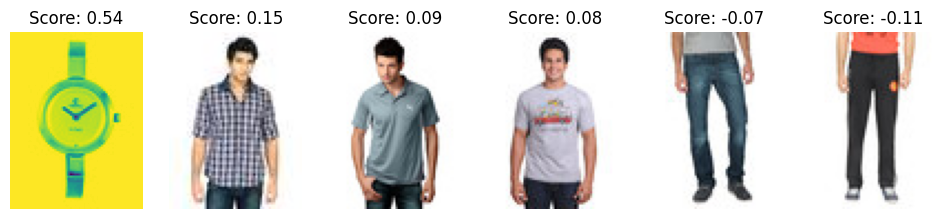

In [30]:
if BERT_RESNET:
    test_clip(model, tokenizer, image_ids, test_text, image_dir, device)

In [31]:
if BERT_RESNET:
    find_top_matches(
        model,
        tokenizer,
        text="Pink dress",
        image_embeddings_path=f"{DATA_PATH}image_embeddings_bert_resnet.pt",
        device=device,
        top_k=5,
    )

<ipython-input-11-150b441846c0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeddings = torch.load(image_embeddings_path)


FileNotFoundError: [Errno 2] No such file or directory: './data/image_embeddings_bert_resnet.pt'

## BERT VIT

### Create model

In [14]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.fc = nn.Linear(self.vit.config.hidden_size, embed_dim)

    def forward(self, x):
        outputs = self.vit(pixel_values=x)
        return self.fc(outputs.pooler_output)

class TextEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(self.bert.config.hidden_size, embed_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(outputs.pooler_output)

In [15]:
class CLIP(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.image_encoder = ImageEncoder(embed_dim)
        self.text_encoder = TextEncoder(embed_dim)
        self.temperature = nn.Parameter(torch.ones([]) * 0.07)

    def forward(self, images, input_ids, attention_mask):
        img_embeddings = self.image_encoder(images)
        txt_embeddings = self.text_encoder(input_ids, attention_mask)
        img_embeddings = img_embeddings / img_embeddings.norm(dim=1, keepdim=True)
        txt_embeddings = txt_embeddings / txt_embeddings.norm(dim=1, keepdim=True)
        return img_embeddings, txt_embeddings, self.temperature

In [16]:
if BERT_VIT and TRAIN_MODELS:
    model_vit = CLIP(embed_dim=128)
    optimizer = torch.optim.Adam(model_vit.parameters(), lr=1e-4)

    train_clip(model_vit, data_loader, optimizer, device, epochs=5)
    torch.save(model_vit, DATA_PATH + "clip_model_bert_vit.pth")

### Test model

In [17]:
if BERT_VIT:
    model_vit = torch.load(DATA_PATH + "clip_model_bert_vit.pth", map_location=device)

<ipython-input-17-d7c58878f29b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vit = torch.load("/content/drive/My Drive/clip_model_bert_vit_save.pth", map_location=

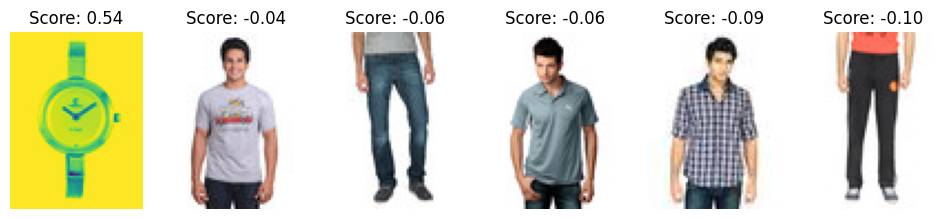

In [20]:
if BERT_VIT:
    test_clip(model_vit, tokenizer, image_ids, test_text, image_dir, device)

In [ ]:
if BERT_VIT and TRAIN_MODELS:
    save_image_embeddings(model_vit, dataset, image_dir=f"{path}/images", device=device, save_path=f"{DATA_PATH}image_embeddings_bert_vit.pt")
    save_text_embeddings(model_vit, tokenizer, dataset, save_path=f"text_embeddings_bert_vit.pt", device=device)

In [25]:
if BERT_VIT:
  results = calculate_clip_accuracy(
      model=model_vit,
      image_embeddings_path="./image_embeddings_bert_vit.pt",
      text_embeddings_path="./text_embeddings_bert_vit.pt",
      device=device,
      top_k=100,
      batch_size=512
  )

  print(f"Accuracy: {results['accuracy']:.2f}%")
  print(f"Top-{results['top_k']} Accuracy: {results['top_k_accuracy']:.2f}%")

Chargement des embeddings...


<ipython-input-13-97d81666e617>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeddings = torch.load(image_embeddings_path, map_location=device)
<ipython-input-13-

Calcul des similarités par batch...


Batch Similarities: 100%|██████████| 87/87 [00:00<00:00, 135.77it/s]


Accuracy: 0.87%
Top-100 Accuracy: 37.11%


In [ ]:
if BERT_VIT:
    find_top_matches(
        model_vit,
        tokenizer,
        text="Blue pants",
        image_embeddings_path=f"{DATA_PATH}image_embeddings_bert_vit.pt",
        device=device,
        top_k=5,
    )

## GPT VIT

### Build model

In [27]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

dataset_gpt = FashionDataset(
    csv_file=f"{path}/styles.csv",
    img_dir=f"{path}/images",
    transform=transform,
    tokenizer=tokenizer
)

# Charger les données dans un DataLoader
if USE_SUBSET:
    subset_gpt = Subset(dataset_gpt, range(SUBSET_SIZE))
    data_loader_gpt = DataLoader(subset_gpt, batch_size=batch_size, shuffle=True)
else:
    data_loader_gpt = DataLoader(dataset_gpt, batch_size=batch_size, shuffle=True)

In [28]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.fc = nn.Linear(self.vit.config.hidden_size, embed_dim)

    def forward(self, x):
        outputs = self.vit(pixel_values=x)
        return self.fc(outputs.pooler_output)

class TextEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.gpt = GPT2Model.from_pretrained("gpt2")
        self.fc = nn.Linear(self.gpt.config.hidden_size, embed_dim)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.gpt(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(outputs.last_hidden_state[:, -1, :])

In [29]:
class CLIP(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.image_encoder = ImageEncoder(embed_dim)
        self.text_encoder = TextEncoder(embed_dim)
        self.temperature = nn.Parameter(torch.ones([]) * 0.07)

    def forward(self, images, input_ids, attention_mask):
        img_embeddings = self.image_encoder(images)
        txt_embeddings = self.text_encoder(input_ids, attention_mask)
        img_embeddings = img_embeddings / img_embeddings.norm(dim=1, keepdim=True)
        txt_embeddings = txt_embeddings / txt_embeddings.norm(dim=1, keepdim=True)
        return img_embeddings, txt_embeddings, self.temperature

In [30]:
if GPT_VIT and TRAIN_MODELS:
    model_gpt_vit = CLIP(embed_dim=128)
    optimizer = torch.optim.Adam(model_gpt_vit.parameters(), lr=1e-4)

    train_clip(model_gpt_vit, data_loader_gpt, optimizer, device, epochs=5)
    torch.save(model_gpt_vit, DATA_PATH + "clip_model_gpt_vit.pth")

In [33]:
if GPT_VIT:
    model_gpt_vit = torch.load(DATA_PATH + "clip_model_gpt_vit_save.pth", map_location=device)

<ipython-input-33-19b307162023>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_gpt_vit = torch.load("/content/drive/My Drive/clip_model_gpt_vit_save.pth", map_locati

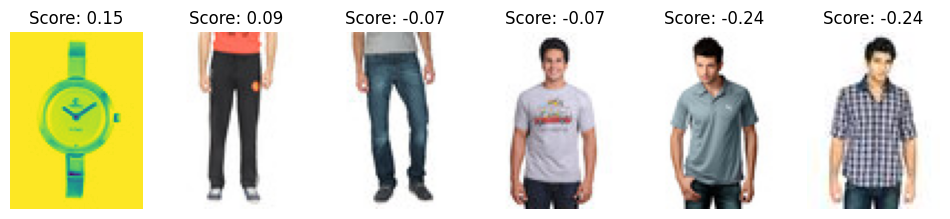

In [34]:
if GPT_VIT:
    test_clip(model_gpt_vit, tokenizer, image_ids, test_text, image_dir, device)

In [35]:
if BERT_VIT and TRAIN_MODELS:
    save_image_embeddings(model_gpt_vit, dataset, image_dir=f"{path}/images", device=device, save_path=f"{DATA_PATH}image_embeddings_gpt_vit.pt")
    save_text_embeddings(model_gpt_vit, tokenizer, dataset_gpt, save_path=f"{DATA_PATH}text_embeddings_gpt_vit.pt", device=device)

In [36]:
if GPT_VIT:
  results = calculate_clip_accuracy(
      model=model_gpt_vit,
      image_embeddings_path="./image_embeddings_gpt_vit.pt",
      text_embeddings_path="./text_embeddings_gpt_vit.pt",
      device=device,
      top_k=100,
      batch_size=512
  )

  print(f"Accuracy: {results['accuracy']:.2f}%")
  print(f"Top-{results['top_k']} Accuracy: {results['top_k_accuracy']:.2f}%")

Chargement des embeddings...


<ipython-input-13-97d81666e617>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeddings = torch.load(image_embeddings_path, map_location=device)
<ipython-input-13-

Calcul des similarités par batch...


Batch Similarities: 100%|██████████| 87/87 [00:00<00:00, 134.90it/s]


Accuracy: 0.00%
Top-100 Accuracy: 0.10%


In [37]:
if GPT_VIT:
    find_top_matches(
        model_gpt_vit,
        tokenizer,
        text="Red shoes",
        image_embeddings_path=f"{DATA_PATH}image_embeddings_gpt_vit.pt",
        device=device,
        top_k=5,
    )

<ipython-input-11-150b441846c0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeddings = torch.load(image_embeddings_path)


FileNotFoundError: [Errno 2] No such file or directory: './data/image_embeddings_gpt_vit.pt'